## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.stats.api as sms

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]

In [8]:
all_topics = []
reg_topics = []
simple_reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    simple_reg_topics.append('topic_{}'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*90
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']
all_data['pct_under_30'] = all_data['under_30'] / all_data['total_issues']
all_data['pct_under_60'] = all_data['under_60'] / all_data['total_issues']
all_data['pct_under_90'] = all_data['under_90'] / all_data['total_issues']
all_data['issues_per_user'] = all_data['total_issues'] / all_data['num_users']
all_data.to_csv('/home/matt/research_data_25.csv', index=False)

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

In [13]:
def glm_marginal_effect(variable, res, X, all_data):
    """Computes the GLM marginal effects for the variable.
    
    Parameters
    ----------
    variable : str
        the variable for which we would like to calculate the marginal effect
    res : sm.model
        results of the linear regression
    X : pd.DataFrame
        the input to the linear regression
    all_data : pd.DataFrame
        the full set of input data
        
    Returns
    -------
    marginal_effect : float
    """
    data = all_data.copy(deep=True)
    param = res.params[variable]
    cross_term = '{}Xcrowd_pct'.format(variable)
    if cross_term in res.params:
        data['effect'] = param + data['crowd_pct'] * res.params[cross_term]
    else:
        data['effect'] = param
    data['prediction'] = res.predict(X)
    data['marginal_effect'] = data['effect'] * data['prediction']
    return data['marginal_effect'].mean()

In [14]:
def compute_pca(X, n_components=50):
    """Compute principal component analysis only on the topic columns
    
    Parameters
    ----------
    X : pd.DataFrame
        the dataframe that contains the columns for the regression model
    n_compnents : int
        the number of principal components to retain
        
    Returns
    -------
    final_df : pd.DataFrame
        the data frame for the linear regression, with the topic columns
        replaced by their principal components
    """
    topic_columns = [x for x in X.columns if 'topic' in x]
    topic_matrix = X[topic_columns]
    pca = PCA(n_components=n_components)
    pca_matrix = pca.fit_transform(topic_matrix)
    pca_df = pd.DataFrame(data = pca_matrix, columns = ['pc_{}'.format(i) for i in range(pca_matrix.shape[1])])
    pca_df['index'] = range(len(pca_df))
    X['index'] = range(len(X))
    final_df = X.merge(pca_df)
    del final_df['index']
    for col in final_df:
        if 'topic' in col:
            del final_df[col]
    return final_df

### Exploratory Data Analysis

(0, 1)

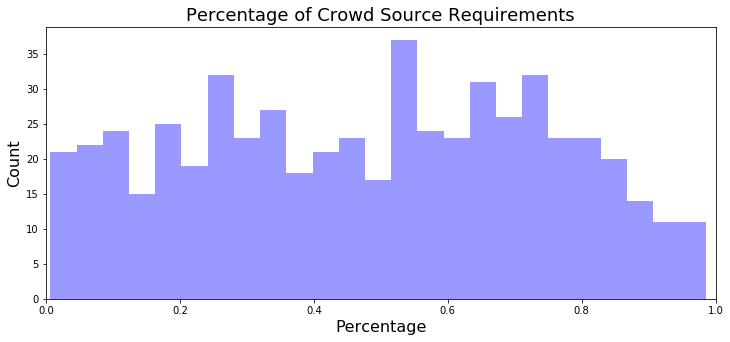

In [15]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['crowd_pct'], kde=False, color='blue', bins=25)
plt.title('Percentage of Crowd Source Requirements', fontsize=18)
plt.xlabel('Percentage', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 1])

(1, 10)

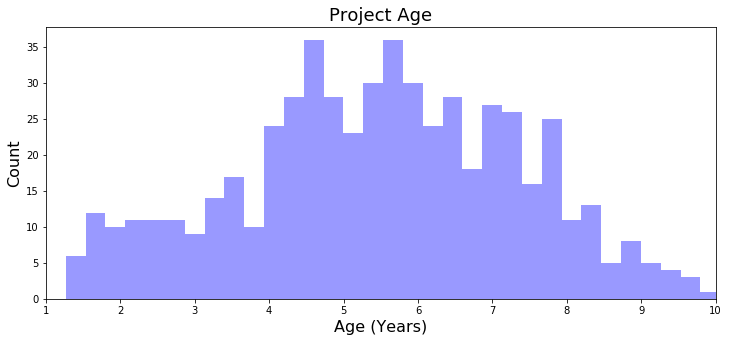

In [16]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['project_age']/365, kde=False, color='blue', bins=54)
plt.title('Project Age', fontsize=18)
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 10])

(1, 40)

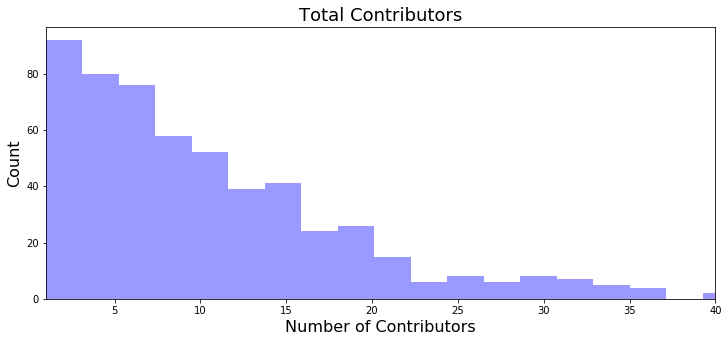

In [17]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_contributors'], kde=False, color='blue', bins=40)
plt.title('Total Contributors', fontsize=18)
plt.xlabel('Number of Contributors', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 40])

(1, 150)

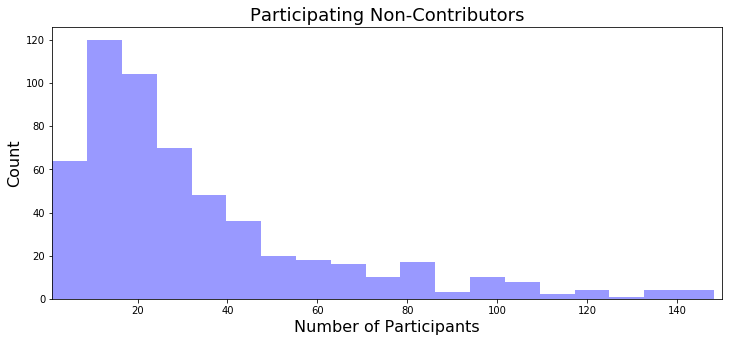

In [18]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['num_users'], kde=False, color='blue', bins=40)
plt.title('Participating Non-Contributors', fontsize=18)
plt.xlabel('Number of Participants', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 150])

(30, 600)

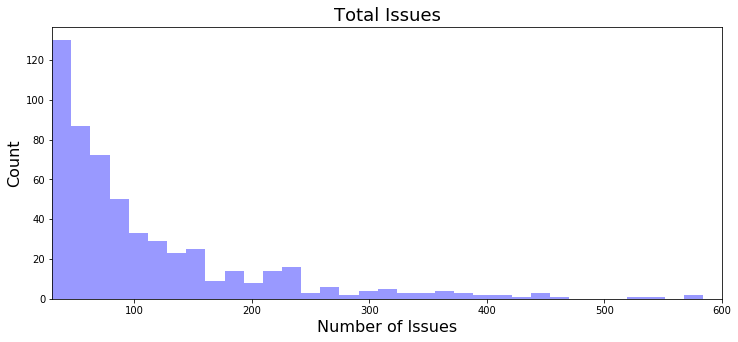

In [19]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_issues'], kde=False, color='blue', bins=100)
plt.title('Total Issues', fontsize=18)
plt.xlabel('Number of Issues', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([30, 600])

In [20]:
all_data[['crowd_pct', 'project_age', 'total_contributors', 'num_users', 'total_issues']].describe()

,crowd_pct,project_age,total_contributors,num_users,total_issues
count,562.000000,562.000000,562.000000,562.000000,562.000000
mean,0.480865,2003.953737,11.539146,34.213523,119.026690
std,0.263940,708.729297,10.587185,32.851103,128.293396
min,0.006711,462.000000,1.000000,1.000000,30.000000
25%,0.265306,1560.000000,5.000000,14.000000,48.250000
50%,0.500000,2023.000000,9.000000,24.000000,77.000000
75%,0.699603,2520.750000,15.000000,42.000000,141.750000
max,0.985294,5716.000000,86.000000,311.000000,1660.000000


In [21]:
(all_data['project_age'] / 365).describe()

count    562.000000
mean       5.490284
std        1.941724
min        1.265753
25%        4.273973
50%        5.542466
75%        6.906164
max       15.660274
Name: project_age, dtype: float64

### Regression on Average Comments

Text(0, 0.5, 'Count')

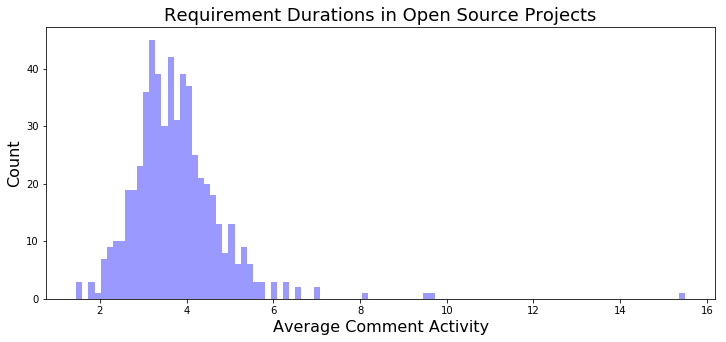

In [22]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Average Comment Activity', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [23]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [24]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:17:11,491 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.35712679732154384
10
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      552
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                        0.051905
Method:                          IRLS   Log-Likelihood:                -648.96
Date:                Thu, 23 Jan 2020   Deviance:                       24.408
Time:                        22:17:11   Pearson chi2:                     28.7
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [25]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 2.585369978377552
avg_min_path: -1.7431070983871815
gini_coefficient: 5.26331399472649


In [26]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age +
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    topic_0:topic_1 + topic_0:topic_7 + topic_0:topic_9 + topic_0:topic_10 + 
    topic_0:topic_18 + topic_0:topic_19 + topic_0:topic_21 + 
    topic_1:topic_2 + topic_1:topic_9 + topic_1:topic_10 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_21 + topic_2:topic_11 + 
    topic_2:topic_12 + topic_2:topic_18 + topic_2:topic_20 + 
    topic_2:topic_22 + topic_3:topic_5 + topic_3:topic_11 + topic_3:topic_21 + 
    topic_4:topic_8 + topic_4:topic_18 + topic_5:topic_7 + topic_5:topic_9 + 
    topic_5:topic_11 + topic_5:topic_15 + topic_5:topic_17 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_8 + topic_6:topic_12 + 
    topic_6:topic_14 + topic_6:topic_16 + topic_6:topic_17 + 
    topic_6:topic_18 + topic_6:topic_19 + topic_7:topic_8 + topic_7:topic_16 + 
    topic_7:topic_23 + topic_8:topic_9 + topic_8:topic_15 + topic_9:topic_10 + 
    topic_9:topic_16 + topic_9:topic_19 + topic_9:topic_20 + 
    topic_9:topic_22 + topic_10:topic_12 + topic_10:topic_16 + 
    topic_10:topic_20 + topic_10:topic_22 + topic_10:topic_23 + 
    topic_11:topic_13 + topic_11:topic_14 + topic_11:topic_15 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_22 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_22 + 
    topic_15:topic_16 + topic_15:topic_18 + topic_15:topic_21 + 
    topic_16:topic_19 + topic_16:topic_22 + topic_17:topic_18 + 
    topic_17:topic_20 + topic_17:topic_22 + topic_18:topic_23 + 
    topic_19:topic_20 + topic_19:topic_21 + topic_19:topic_23 + 
    topic_20:topic_21 + topic_21:topic_22 + topic_3:topic_8 + 
    topic_7:topic_18 + topic_5:topic_12

"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 80)
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:17:12,864 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:38: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



0.5231871858054602
90
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      472
Model Family:                   Gamma   Df Model:                           89
Link Function:                    log   Scale:                        0.042332
Method:                          IRLS   Log-Likelihood:                -569.92
Date:                Thu, 23 Jan 2020   Deviance:                       18.103
Time:                        22:17:13   Pearson chi2:                     20.0
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [27]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 2.4166899879959076
avg_min_path: -1.8674107849222668
gini_coefficient: 4.920280750345791


In [28]:
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

0.16351645831390046


2020-01-23 22:17:15,594 [1531] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

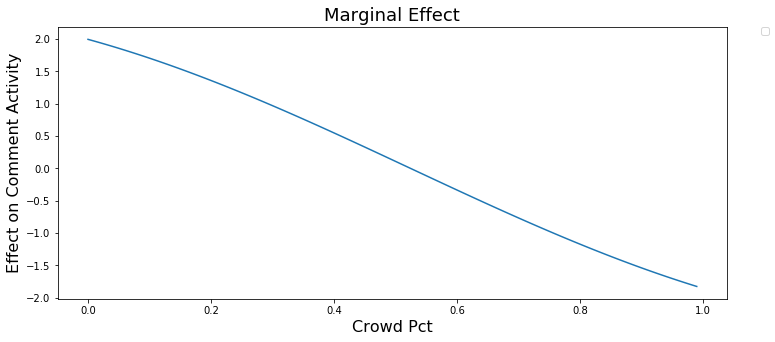

In [29]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

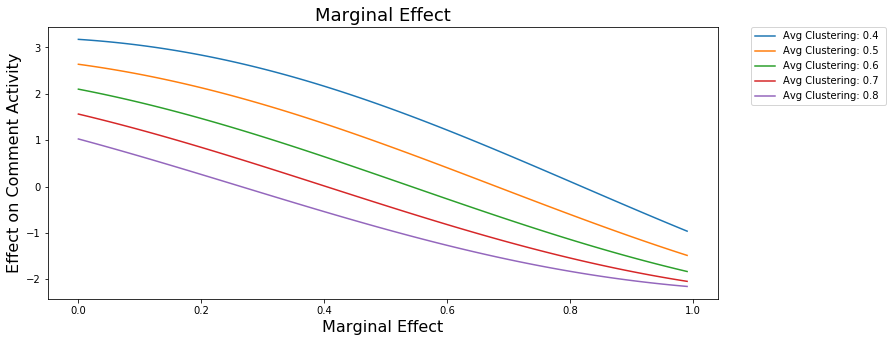

In [30]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

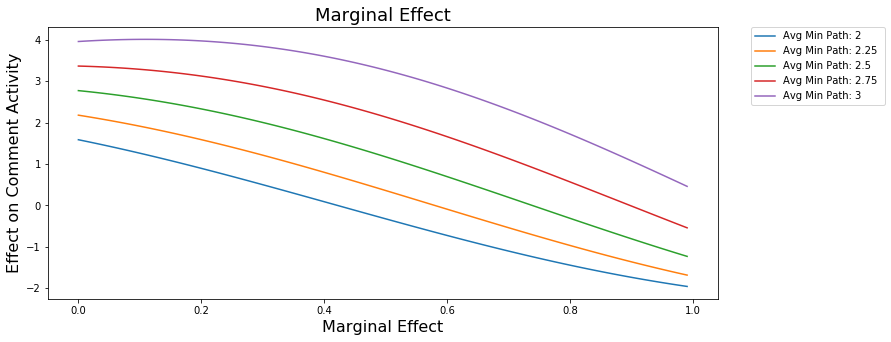

In [31]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

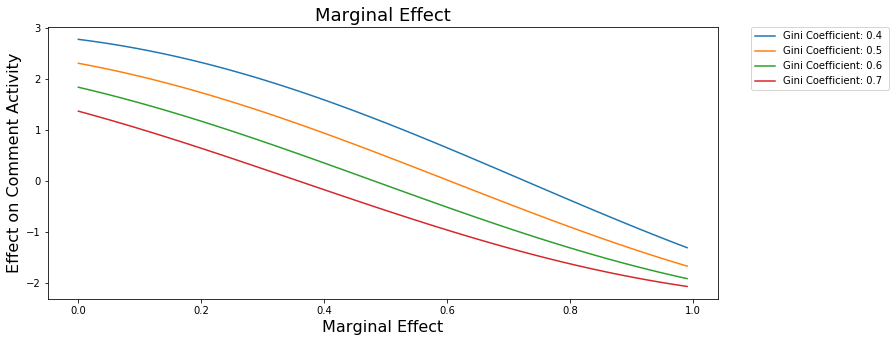

In [32]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Issues Submitted Over Time

(0, 40)

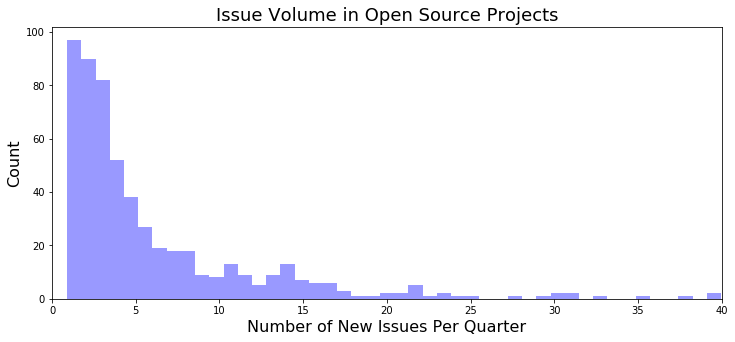

In [33]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume in Open Source Projects', fontsize=18)
plt.xlabel('Number of New Issues Per Quarter', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 40])

In [34]:
all_data['issues_over_time'].describe()

count    562.000000
mean       6.559592
std        8.401885
min        0.902708
25%        2.160445
50%        3.603278
75%        7.565225
max       85.820896
Name: issues_over_time, dtype: float64

In [35]:
formula = """
issues_over_time ~ crowd_pct_2 + avg_clustering + 
    gini_coefficient + avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + 
    gini_coefficientXcrowd_pct + total_contributors + project_age + avg_min_path
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:17:45,091 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.6532224016228738
10
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      552
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                         0.44244
Method:                          IRLS   Log-Likelihood:                -1310.9
Date:                Thu, 23 Jan 2020   Deviance:                       173.54
Time:                        22:17:45   Pearson chi2:                     244.
No. Iterations:                    34                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [36]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: -3.500158921949096
avg_min_path: 0.12350501444395257
gini_coefficient: 17.862691162691885


In [37]:
avg_clustering = all_data['avg_clustering']
avg_min_path = all_data['avg_min_path']
crowd_pct = all_data['crowd_pct']


effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-8.5961030069771


2020-01-23 22:17:47,020 [1531] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

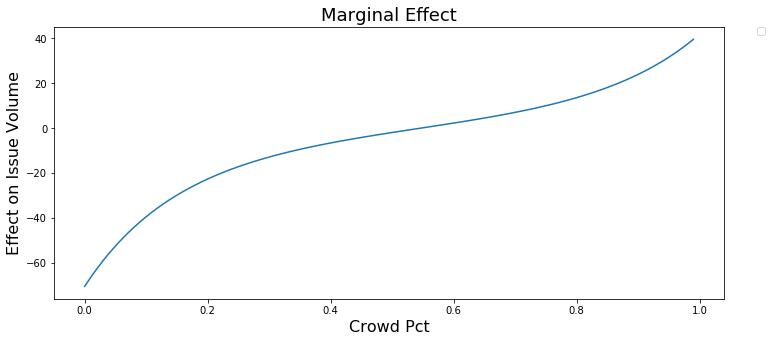

In [38]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct_2'] = crowd_pct**2

    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

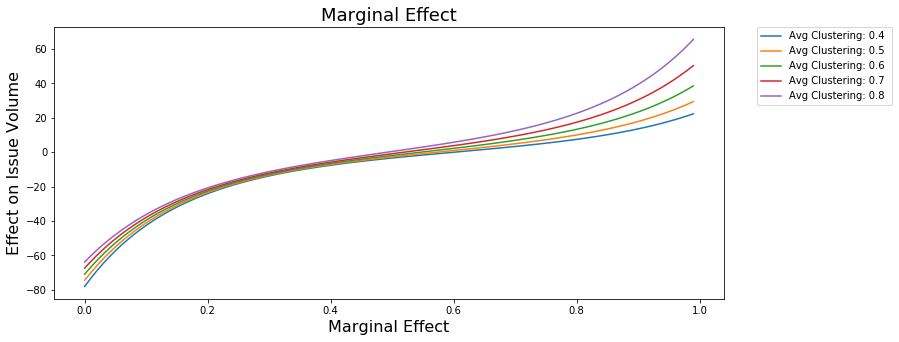

In [39]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

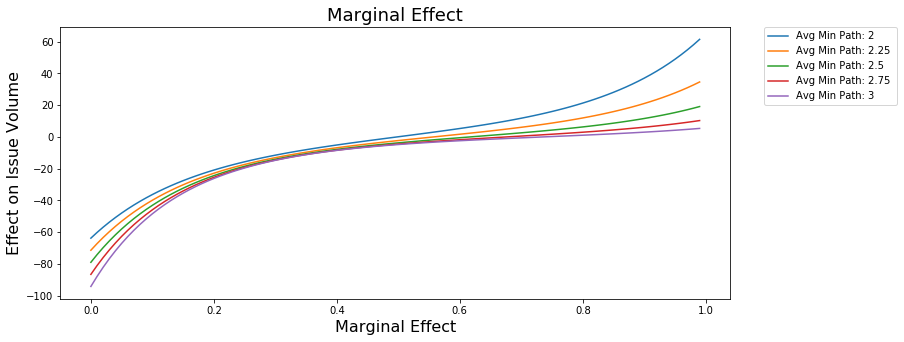

In [40]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

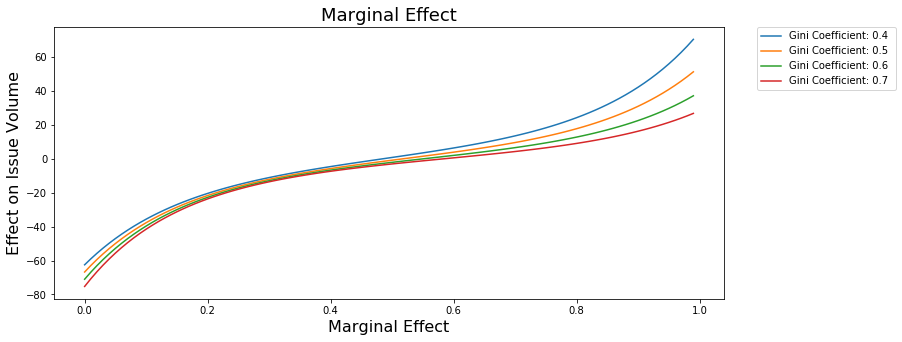

In [41]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Avg First Comment Time

In [42]:
all_data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

(0, 150)

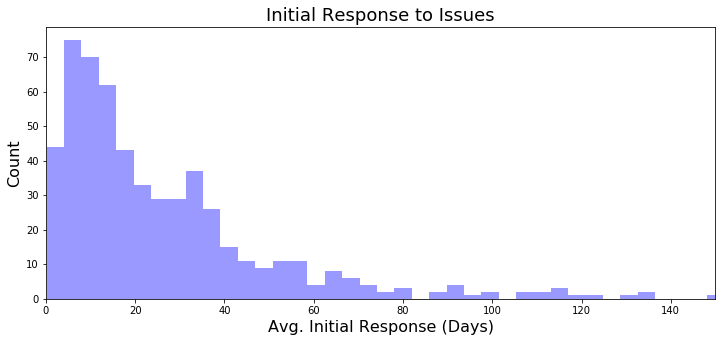

In [43]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Initial Response to Issues', fontsize=18)
plt.xlabel('Avg. Initial Response (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 150])

In [44]:
formula = """
avg_first_comment ~ crowd_pct + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    + project_age 
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:18:11,683 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.41068925063270356
7
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      555
Model Family:                   Gamma   Df Model:                            6
Link Function:                    log   Scale:                         0.79809
Method:                          IRLS   Log-Likelihood:                -2303.9
Date:                Thu, 23 Jan 2020   Deviance:                       353.14
Time:                        22:18:11   Pearson chi2:                     443.
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
In

In [45]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 19.97455459707392
avg_min_path: 39.342682158200994
gini_coefficient: -182.17349886563466


In [46]:
marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)
effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


effects_data['crowd_pct'] = crowd_pct

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-4.1508079401491935


2020-01-23 22:18:13,135 [1531] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

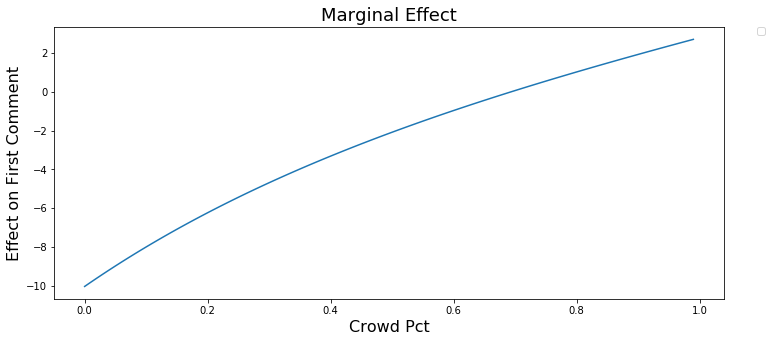

In [47]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


    effects_data['crowd_pct'] = crowd_pct

    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

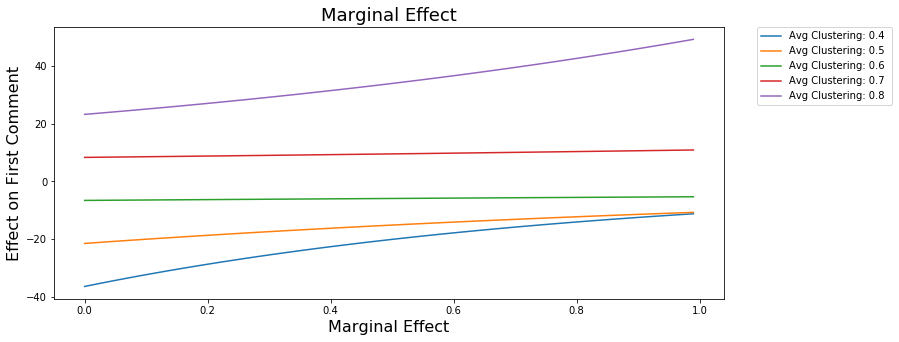

In [48]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering

        effects_data['crowd_pct'] = crowd_pct


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Issues Per User

In [49]:
all_data['issues_per_user'].describe()

count    562.000000
mean       5.422194
std        8.544846
min        1.113402
25%        2.192618
50%        3.177866
75%        5.174578
max       97.000000
Name: issues_per_user, dtype: float64

(0, 40)

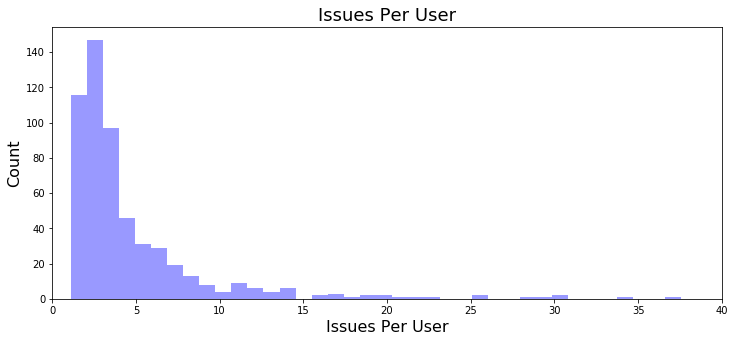

In [50]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_per_user'], kde=False, color='blue', bins=100)
plt.title('Issues Per User', fontsize=18)
plt.xlabel('Issues Per User', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 40])

In [51]:
formula = """
issues_per_user ~ crowd_pct + crowd_pct_2 + avg_min_path   
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:18:19,027 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.6440481133050244
4
                 Generalized Linear Model Regression Results                  
Dep. Variable:        issues_per_user   No. Observations:                  562
Model:                            GLM   Df Residuals:                      558
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.66202
Method:                          IRLS   Log-Likelihood:                -1281.1
Date:                Thu, 23 Jan 2020   Deviance:                       154.15
Time:                        22:18:19   Pearson chi2:                     369.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1701    

In [52]:
glm_marginal_effect('avg_min_path', res, X, all_data)

2.782951542693354

In [53]:
marginal_effects = {'crowd_pct': [], 'effect': []}
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)
effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2


effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = res.params['crowd_pct']
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-19.481844172592673


### Average Active Time

In [54]:
all_data['avg_active_time'].describe()

count    562.000000
mean      68.128883
std       52.051931
min        0.675000
25%       31.744782
50%       55.716894
75%       88.387924
max      531.482618
Name: avg_active_time, dtype: float64

In [55]:
formula = """
avg_active_time ~ crowd_pct + avg_min_path + avg_clustering + gini_coefficient +
                    avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + 
                     project_age
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-23 22:18:20,681 [1531] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.50713968402298
9
                 Generalized Linear Model Regression Results                  
Dep. Variable:        avg_active_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      553
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.30097
Method:                          IRLS   Log-Likelihood:                -2664.6
Date:                Thu, 23 Jan 2020   Deviance:                       153.26
Time:                        22:18:20   Pearson chi2:                     166.
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
I

In [56]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, all_data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 136.43682241461963
avg_min_path: 5.837699537149597
gini_coefficient: -147.2379687237177


In [57]:
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct'] = crowd_pct

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

59.622994041296295


2020-01-23 22:18:22,388 [1531] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

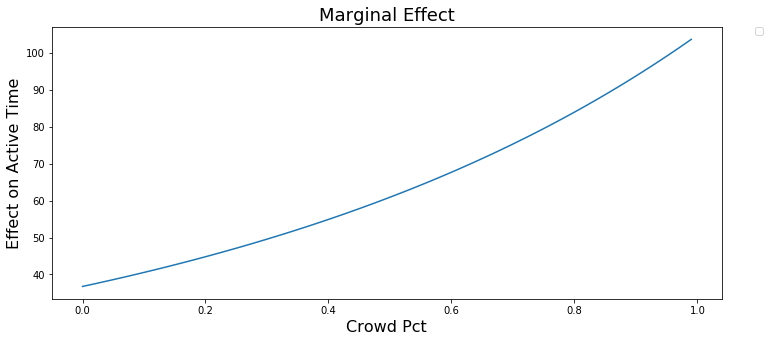

In [58]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct'] = crowd_pct

    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

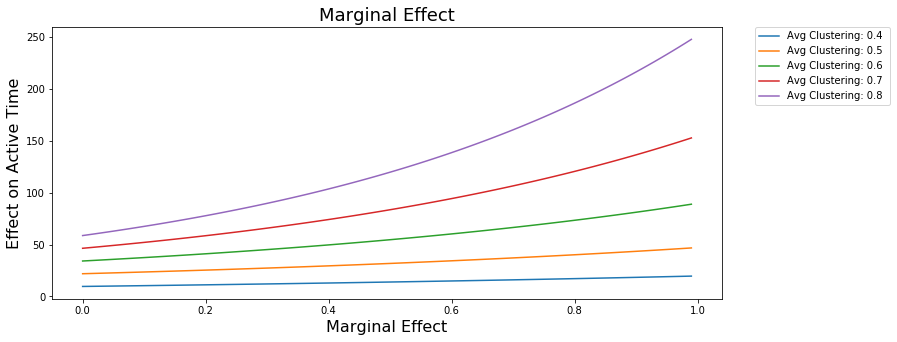

In [59]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

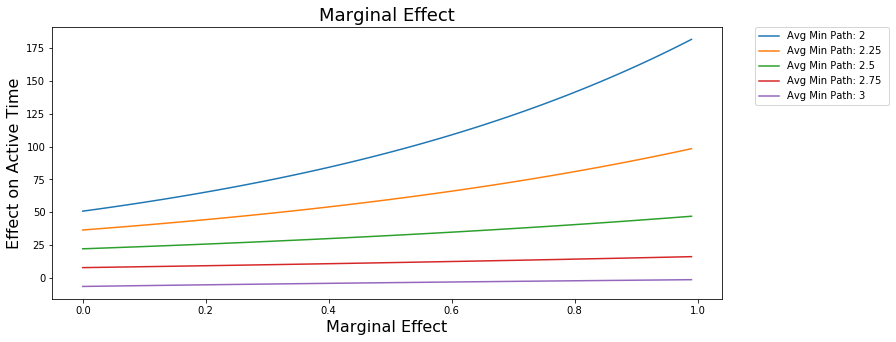

In [60]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Active Time', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

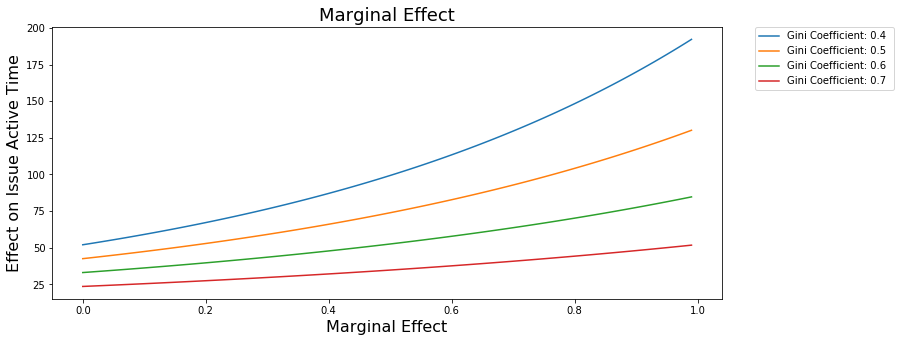

In [61]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * effects_data['crowd_pct_param']
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Active Time', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)